In [1]:
from keras.applications import inception_v3
import keras
import tensorflow as tf
import pandas as pd
import numpy as np
from skimage import io,transform
import os
import sys
model_name = 'InceptionV3_RealSpam'

Using TensorFlow backend.


In [2]:
# size = 299
# counter = 0
# spamFolder = '../Images/SpamReal/Spam/'
# imageFiles = os.listdir(spamFolder)
# total = len(imageFiles)
# spam_images = []
# for image_path in imageFiles:
#     if not image_path.endswith('.jpg'):
#         continue
#     img = io.imread(os.path.join(spamFolder,image_path))
#     img = transform.resize(img, (size,size,3))
#     spam_images.append(img)
#     counter += 1
#     sys.stdout.write("\rProcessed: {0}/{1}".format(counter, total))
#     sys.stdout.flush()
# print('')
# counterA = 0
# realFolder = '../Images/SpamReal/Real/'
# imageFiles = os.listdir(realFolder)
# total = len(imageFiles)    
# real_images = []
# for image_path in os.listdir(realFolder):
#     if not image_path.endswith('.jpg'):
#         continue
#     img = io.imread(os.path.join(realFolder,image_path))
#     img = transform.resize(img, (size,size,3))
#     real_images.append(img)
#     counterA += 1
#     sys.stdout.write("\rProcessed: {0}/{1}".format(counterA, total))
#     sys.stdout.flush()
    
# x = np.array(spam_images+real_images)
# y = np.array(([0] * len(spam_images)) + ([1] * len(real_images)))
# y = keras.utils.to_categorical(y, 2)

# import random
# c = list(zip(x, y))
# random.shuffle(c)
# x, y = zip(*c)
# x = np.array(x)
# y = np.array(y)
# np.save('../Images/SpamReal/spamreal_x%s.npy' % size, x)
# np.save('../Images/SpamReal/spamreal_y%s.npy' % size, y)

In [3]:
size=128
x = np.load('../Images/SpamReal/spamreal_x%s.npy' % size)
y = np.load('../Images/SpamReal/spamreal_y%s.npy' % size)

In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7)

In [5]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [6]:
from keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras.models import Model
base = inception_v3.InceptionV3(include_top=False, weights=None, classes=2, input_shape=(size,size,3), pooling='avg')
temp = base.output
# temp = GlobalAveragePooling2D()(temp)
temp = Dropout(0.5)(temp)
predictions = Dense(2, activation= 'softmax')(temp)
model = Model(inputs = base.input, outputs = predictions)

In [16]:
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
# rmsp = rmsprop(lr=0.01, decay=0.9, epsilon=1, clipvalue=2)
model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['acc'])

filepath="%s.best.hdf5" % model_name
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

hist = model.fit([x_train], y_train, batch_size=32, epochs=20, validation_data=([x_test], y_test), verbose=1, callbacks=callbacks_list)

Train on 8397 samples, validate on 2100 samples
Epoch 1/20
8397/8397 [==============================] - 32s 4ms/step - loss: 0.0311 - acc: 0.9899 - val_loss: 0.5959 - val_acc: 0.8776

Epoch 00001: val_loss did not improve from 0.22862
Epoch 2/20
8397/8397 [==============================] - 26s 3ms/step - loss: 0.0351 - acc: 0.9876 - val_loss: 0.3868 - val_acc: 0.9024

Epoch 00002: val_loss did not improve from 0.22862
Epoch 3/20
8397/8397 [==============================] - 26s 3ms/step - loss: 0.0454 - acc: 0.9851 - val_loss: 0.4649 - val_acc: 0.8890

Epoch 00003: val_loss did not improve from 0.22862
Epoch 4/20
8397/8397 [==============================] - 26s 3ms/step - loss: 0.0252 - acc: 0.9902 - val_loss: 0.3903 - val_acc: 0.9038

Epoch 00004: val_loss did not improve from 0.22862
Epoch 5/20
8397/8397 [==============================] - 26s 3ms/step - loss: 0.0268 - acc: 0.9906 - val_loss: 0.7952 - val_acc: 0.8438

Epoch 00005: val_loss did not improve from 0.22862
Epoch 6/20
8397/8

In [6]:
# serialize model to JSON
model_json = model.to_json()
with open("%s.json" % model_name, "w") as json_file:
    json_file.write(model_json)
    
# # serialize weights to HDF5
model.save_weights("%s.h5" % model_name)
print("Saved model to disk")

NameError: name 'model' is not defined

In [7]:
from keras.models import model_from_json
# load json and create model
json_file = open('%s.json' % model_name, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("%s.h5" % model_name)
print("Loaded model from disk")

model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['acc'])

Loaded model from disk


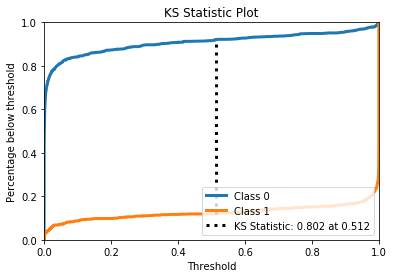

In [20]:
skplt.metrics.plot_ks_statistic(np.array(true), list(zip(1-np.array(pred), np.array(pred))))

precision_score:  0.8948545861297539
recall_score:  0.8810572687224669
f1_score:  0.8879023307436181
roc_auc_score:  0.9619850028087397


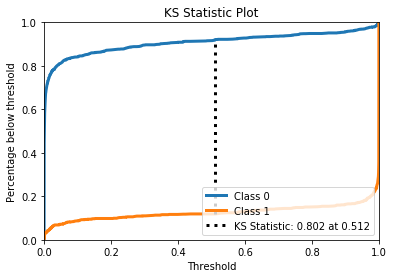

In [9]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, roc_auc_score
import scikitplot as skplt
%matplotlib inline

predicted = model.predict([x_test])
true = []
pred = []
for i in range(len(predicted)):
    p_tmp = predicted[i][1]
    t_tmp = np.argmax(y_test[i], -1)
    pred.append(p_tmp)
    true.append(t_tmp)
pred = np.array(pred)
true = np.array(true)
skplt.metrics.plot_ks_statistic(np.array(true), list(zip(1-pred, pred)))

print("precision_score: ", precision_score(true, pred>=0.512))
print("recall_score: ", recall_score(true, pred>=0.512))
print("f1_score: ", f1_score(true, pred>=0.512))
print("roc_auc_score: ", roc_auc_score(true, pred))

In [18]:
from keras.models import model_from_json
# load json and create model
json_file = open('%s.json' % model_name, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("%s.best.hdf5" % model_name)
print("Loaded model from disk")

model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['acc'])

Loaded model from disk


In [19]:
predicted = model.predict([x_test])
true = []
pred = []
for i in range(len(predicted)):
    p_tmp = np.argmax(predicted[i], axis=-1)
    t_tmp = np.argmax(y_test[i], -1)
    pred.append(p_tmp)
    true.append(t_tmp)

print(precision_score(true, pred))
print(recall_score(true, pred))
print(roc_auc_score(true, pred))
print(f1_score(true, pred))

0.8910112359550562
0.8733480176211453
0.8959860893474855
0.8820912124582869


In [10]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
fpr, tpr, _ = roc_curve(true, predicted[:,1])
np.save('fpr_%s.npy' % model_name, fpr)
np.save('tpr_%s.npy' % model_name, tpr)